In [364]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import load_model
from imutils import paths
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os

In [365]:
ORIG_INPUT_DATASET = "D:/HOUSE_INTERIOR/Bedrooms"

TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

BASE_PATH = "dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"] # "Neutral",

In [366]:
def plot_hist(hist, metric):
     if metric == 'auc':
            plt.plot(hist.history["auc"])
            plt.plot(hist.history["val_auc"])
     else:
            plt.plot(hist.history["loss"])
            plt.plot(hist.history["val_loss"])
     plt.style.use("ggplot")
     plt.title("model {}".format(metric))
     plt.ylabel("{}".format(metric))
     plt.xlabel("epoch")
     plt.legend(["train", "validation"], loc="upper left")
     plt.show()

In [367]:
file_directory = "D:\HOUSE_INTERIOR"
file_name = "labels.txt"
file_path = os.path.join(file_directory, file_name)

with open(file_path, 'r') as f:
    manual_labels = f.read()
    
labels = [i for i in manual_labels]
len(labels)

451

In [368]:
from collections import Counter

print(Counter(labels).keys()) # equals to list(set(words))
print(Counter(labels).values()) # counts the elements' frequency

dict_keys(['O', 'M'])
dict_values([271, 180])


In [369]:
# sorting files in the order they appear
files = os.listdir(ORIG_INPUT_DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

# checking to see the correct file order
files[:5]

['bed_1.jpg', 'bed_2.jpg', 'bed_3.jpg', 'bed_4.jpg', 'bed_8.jpg']

In [370]:
# splitting files into train and test sets
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], labels, stratify=labels, train_size=0.90)

In [371]:
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)

In [372]:
len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

In [373]:
# Building the dataset properly - 
splits = [(trainX, trainY), (testX, testY), (valX, valY)]
dirnames = ['training', 'evaluation', 'validation']

for i, (data,label) in enumerate(splits):
    outside_dir=dirnames[i]

    for j in tqdm(range(0, len(label)), desc="Iterating over images in sub folder"):
        dir = label[j]
        
        # construct the path to the sub-directory
        dirPath = os.path.join(BASE_PATH, outside_dir, dir)
        
        # if the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            
            
        # copy the img to this new directory
        src_img = os.path.join(ORIG_INPUT_DATASET, data[j])
        shutil.copy(src_img, dirPath)

Iterating over images in sub folder: 100%|██████████| 61/61 [00:00<00:00, 554.03it/s]


In [374]:
trainPath = os.path.join(BASE_PATH, TRAIN)
valPath = os.path.join(BASE_PATH, VAL)
testPath = os.path.join(BASE_PATH, TEST)

In [375]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [376]:
print(totalTrain, totalTest, totalVal)

344 46 61


In [377]:
trainAug = ImageDataGenerator(
rotation_range=90,
zoom_range=[0.5, 1.0],
width_shift_range=0.3,
height_shift_range=0.25,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest",
brightness_range=[0.2, 1.0]
)

In [378]:
# Default for all the above parameters is 0, 
# meaning we are applying no augmentation to val set
# which is exactly what we need because val set should be treated like test set.
valAug = ImageDataGenerator()

In [379]:
testAug = ImageDataGenerator()

In [380]:
# Create training batches whilst creating augmented images on the fly
trainGen = trainAug.flow_from_directory(
directory=trainPath,
target_size=(224,224),
save_to_dir='D:/HOUSE_INTERIOR/dataset/augmented images',
save_prefix='train',
shuffle=True
)

Found 344 images belonging to 2 classes.


In [381]:
print(trainGen)

In [382]:
valGen = valAug.flow_from_directory(
    directory=valPath,
    target_size=(224,224),
    shuffle=True
)

Found 61 images belonging to 2 classes.


In [383]:
print(valGen)

In [384]:
testGen = testAug.flow_from_directory(
    directory=testPath,
    target_size=(224,224),
    shuffle=False
)


Found 46 images belonging to 2 classes.


In [385]:
def build_model():
    # Building the original base EfficientNet-0 model
    baseModel = EfficientNetB0(weights="imagenet", 
                  include_top=False, # make sure top layer i.e. head is not included
                  input_tensor=Input(shape=(224, 224, 3)),
                  pooling="avg"
                  )
    
    # freeze the weights
    for layer in baseModel.layers:
        layer.trainable = False
    
    # training a new classifier on top
    x = baseModel.output
    Layer_1 = BatchNormalization()(x)
    Layer_2 = Dropout(0.50)(Layer_1)
    #Layer_3=  Dense(units=64, activation='sigmoid')(Layer_2)
    output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
    
    model = Model(inputs = baseModel.input, outputs = output_layer)
    
    # compile
    opt = Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [386]:
tf.keras.backend.clear_session()

In [387]:
model_preprocess = build_model() 

In [388]:
# implementing early stopping

es = EarlyStopping(monitor='val_loss',  #metric to monitor
                   mode='min',  # whether to minimize or maximize the metric monitored
                   patience=10,  # how many epochs to wait before declaring stopped training
                   verbose=1  # output epoch when training was stopped
                   )

In [389]:
# model checkpoint - save the best model with best accuracy on val set
mc = ModelCheckpoint('feature_extraction.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     verbose=1, # will tell the epoch+ accuracy everytime model is saved
                     save_best_only=True)

In [390]:
# Training the model
hist = model_preprocess.fit(
    x=trainGen,
    epochs=25,
    verbose=2,
    validation_data=valGen,
    #shuffle=True, # argument is ignored when `x` is a generator
    steps_per_epoch=totalTrain // BATCH_SIZE,
    callbacks=[es, mc]
)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.75074, saving model to feature_extraction.h5
10/10 - 72s - loss: 1.0157 - auc: 0.5197 - val_loss: 0.7507 - val_auc: 0.3461 - 72s/epoch - 7s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.75074 to 0.72310, saving model to feature_extraction.h5
10/10 - 53s - loss: 0.9274 - auc: 0.5796 - val_loss: 0.7231 - val_auc: 0.4402 - 53s/epoch - 5s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.72310 to 0.70183, saving model to feature_extraction.h5
10/10 - 53s - loss: 0.8707 - auc: 0.6373 - val_loss: 0.7018 - val_auc: 0.5542 - 53s/epoch - 5s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.70183 to 0.68529, saving model to feature_extraction.h5
10/10 - 53s - loss: 0.8374 - auc: 0.6307 - val_loss: 0.6853 - val_auc: 0.6092 - 53s/epoch - 5s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.68529 to 0.67266, saving model to feature_extraction.h5
10/10 - 54s - loss: 0.8372 - auc: 0.6474 - val_loss: 0.6727 - val_auc: 0.6275 - 54s/epoch - 5s

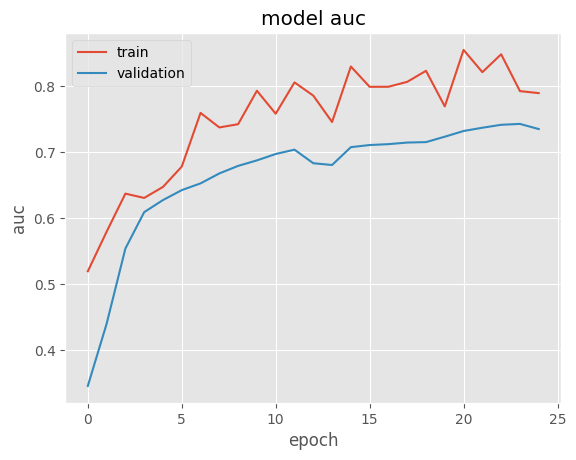

In [391]:
plot_hist(hist, metric="auc")

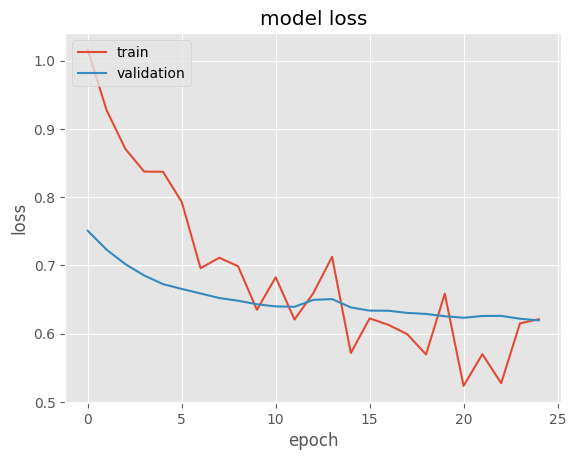

In [392]:
# plotting losses to see if it would have benefitted from more epochs

plot_hist(hist, metric="loss")

2/2 [==============================] - 3s 666ms/step
No. of test images 46
{'M': 0, 'O': 1}


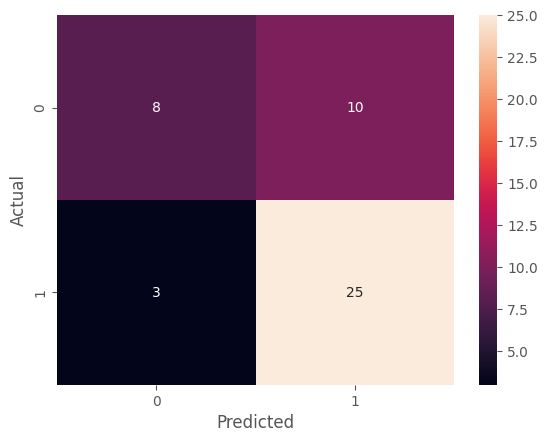

In [393]:
# Checking the performance on testset
testGen.reset()

predIdxs = model_preprocess.predict(x=testGen, 
                                    steps=(totalTest // BATCH_SIZE) + 1
                                    )

predIdxs = np.argmax(predIdxs, axis = 1)
print("No. of test images", len(predIdxs))
print(testGen.class_indices)

cm = confusion_matrix(testGen.classes, predIdxs)

heatmap = sns.heatmap(cm, annot=True)

plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.show()

In [394]:
tf.keras.backend.clear_session()

In [395]:
def fine_tune_model(model):
    
    # unfreeze last conv block i.e. block7a which can be found in top 20 layers
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            
    # check which of these are trainable and which aren't
    for layer in model.layers:
	    print("{}: {}".format(layer, layer.trainable))
     
     
    # compile (with an even smaller learning rate)
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [396]:
model_fine_tuned = fine_tune_model(model_preprocess)

<keras.engine.input_layer.InputLayer object at 0x000002646952E610>: False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000002646FB6F460>: False
<keras.layers.preprocessing.normalization.Normalization object at 0x000002646952E7C0>: False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x000002646FB75100>: False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002646FB75220>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002646FB6F3D0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002646FB7FBE0>: False
<keras.layers.core.activation.Activation object at 0x000002646FB68940>: False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x00000264695189A0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000026466C60220>: False
<keras.layers.core.activation.Activation object at 0x000002646FB752E0>: False
<keras.layers.pooling.global

In [397]:
# training the model

# Before proceeding with training again, lets reset our train and valgen so that they start with sample #0
trainGen.reset()
valGen.reset()

es_tune = EarlyStopping(monitor='val_loss',  
                   mode='min',  
                   patience=20,  
                   verbose=1  
                   )

mc_tune = ModelCheckpoint('fine_tuned_house.h5', 
                    monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    save_best_only=True)

hist = model_fine_tuned.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valGen,
	epochs=50,
 	verbose=2,
  	callbacks=[es_tune, mc_tune]
  )

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.62020, saving model to fine_tuned_house.h5
10/10 - 31s - loss: 0.5631 - auc: 0.8286 - val_loss: 0.6202 - val_auc: 0.7431 - 31s/epoch - 3s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.62020
10/10 - 25s - loss: 0.5708 - auc: 0.8268 - val_loss: 0.6209 - val_auc: 0.7440 - 25s/epoch - 3s/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.62020
10/10 - 26s - loss: 0.5878 - auc: 0.8229 - val_loss: 0.6205 - val_auc: 0.7490 - 26s/epoch - 3s/step
Epoch 4/50

Epoch 4: val_loss improved from 0.62020 to 0.61993, saving model to fine_tuned_house.h5
10/10 - 27s - loss: 0.5284 - auc: 0.8501 - val_loss: 0.6199 - val_auc: 0.7482 - 27s/epoch - 3s/step
Epoch 5/50

Epoch 5: val_loss improved from 0.61993 to 0.61910, saving model to fine_tuned_house.h5
10/10 - 26s - loss: 0.5045 - auc: 0.8623 - val_loss: 0.6191 - val_auc: 0.7509 - 26s/epoch - 3s/step
Epoch 6/50

Epoch 6: val_loss improved from 0.61910 to 0.61892, saving model to fine_t

Epoch 46/50

Epoch 46: val_loss improved from 0.60283 to 0.60186, saving model to fine_tuned_house.h5
10/10 - 25s - loss: 0.5203 - auc: 0.8539 - val_loss: 0.6019 - val_auc: 0.7794 - 25s/epoch - 3s/step
Epoch 47/50

Epoch 47: val_loss improved from 0.60186 to 0.60011, saving model to fine_tuned_house.h5
10/10 - 26s - loss: 0.5359 - auc: 0.8407 - val_loss: 0.6001 - val_auc: 0.7810 - 26s/epoch - 3s/step
Epoch 48/50

Epoch 48: val_loss improved from 0.60011 to 0.59991, saving model to fine_tuned_house.h5
10/10 - 27s - loss: 0.5402 - auc: 0.8475 - val_loss: 0.5999 - val_auc: 0.7810 - 27s/epoch - 3s/step
Epoch 49/50

Epoch 49: val_loss improved from 0.59991 to 0.59918, saving model to fine_tuned_house.h5
10/10 - 27s - loss: 0.4899 - auc: 0.8676 - val_loss: 0.5992 - val_auc: 0.7815 - 27s/epoch - 3s/step
Epoch 50/50

Epoch 50: val_loss improved from 0.59918 to 0.59903, saving model to fine_tuned_house.h5
10/10 - 27s - loss: 0.4864 - auc: 0.8681 - val_loss: 0.5990 - val_auc: 0.7803 - 27s/epoch 

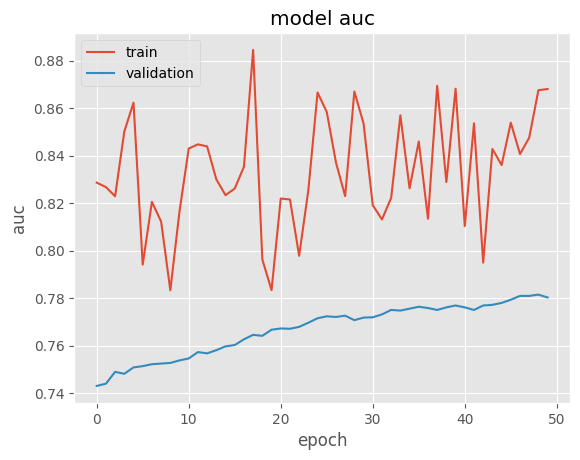

In [405]:
plot_hist(hist, metric="auc")

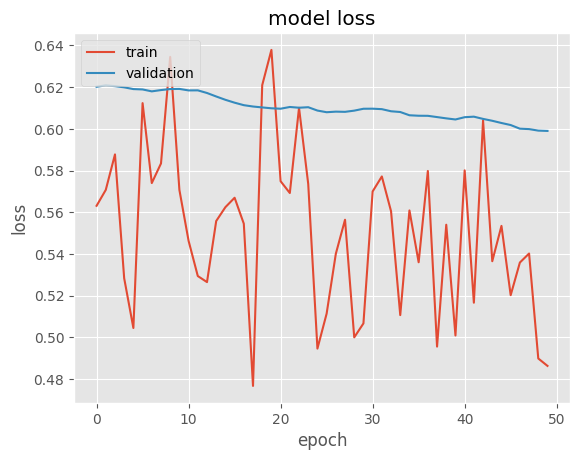

In [399]:
plot_hist(hist, metric="loss")

In [400]:
testGen.reset()

predIdxs = model_fine_tuned.predict(x=testGen, 
                                    steps=(totalTest // BATCH_SIZE) + 1
                                    )

predIdxs = np.argmax(predIdxs, axis = 1)
len(predIdxs)

2/2 [==============================] - 3s 644ms/step


46

In [401]:
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           M       0.63      0.67      0.65        18
           O       0.78      0.75      0.76        28

    accuracy                           0.72        46
   macro avg       0.70      0.71      0.71        46
weighted avg       0.72      0.72      0.72        46



In [402]:
cm = confusion_matrix(testGen.classes, predIdxs)

In [403]:
print(Counter(testY).keys()) # equals to list(set(words))
print(Counter(testY).values()) # counts the elements' frequency

dict_keys(['O', 'M'])
dict_values([28, 18])


{'M': 0, 'O': 1}


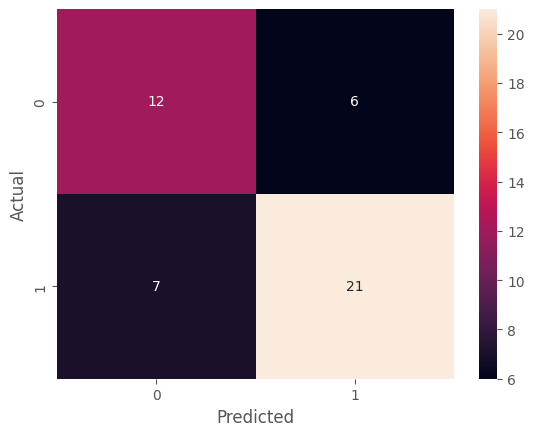

In [404]:
print(testGen.class_indices)

heatmap = sns.heatmap(cm, annot=True)

plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.show()